<a href="https://colab.research.google.com/github/daigo0927/pwcnet/blob/feature%2Fdataset/test_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

## Clone develop branch

In [6]:
# ! git clone -b feature/dataset https://github.com/daigo0927/pwcnet.git

## Install dependent libraries

In [7]:
# ! pip install -U tensorflow tensorflow-addons 

## Change directory

In [8]:
# %cd pwcnet/pwcnet
%ls 

__init__.py            flow_vis.py            package-lock.json
__pycache__/           layers.py              test_components.ipynb
datasets.py            layers.py~
datasets.py~           node_modules/


## Import libraries

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from functools import partial
from flow_vis import flow_to_color, flow_to_quiver, show_image_and_flow

from datasets import (
    normalize,
    random_crop,
    random_horizontal_flip, hflip,
    random_vertical_flip, vflip,
)
from layers import (
    nearest_warp, bilinear_warp, dense_warp,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create sample data

## Visualize the optical flow color palette

fx
 [[-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 ...
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]]
fy
 [[-16 -16 -16 ... -16 -16 -16]
 [-15 -15 -15 ... -15 -15 -15]
 [-14 -14 -14 ... -14 -14 -14]
 ...
 [ 13  13  13 ...  13  13  13]
 [ 14  14  14 ...  14  14  14]
 [ 15  15  15 ...  15  15  15]]


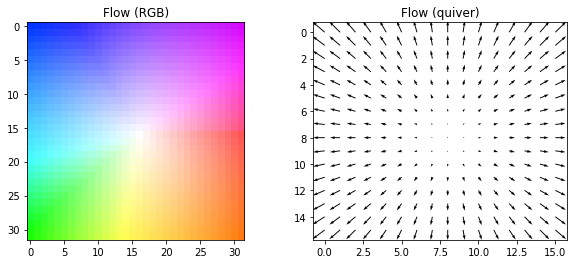

In [10]:
w, h = 32, 32
f = np.arange(-16, 16)
fx = np.tile(f.reshape(1, -1), reps=[h, 1])
fy = np.tile(f.reshape(-1, 1), reps=[1, w])
print('fx\n', fx)
print('fy\n', fy)

flow_sample = np.stack([fx, fy], axis=-1)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
flow_rgb = flow_to_color(flow_sample)
ax1.set_title('Flow (RGB)')
ax1.imshow(flow_rgb)

ax2 = fig.add_subplot(122)
flow_quiver = flow_to_quiver(flow_sample[::2, ::2])
ax2.set_title('Flow (quiver)')
ax2.quiver(*flow_quiver, angles='xy')
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

## Define pre/post-warp image (cyclic warp)

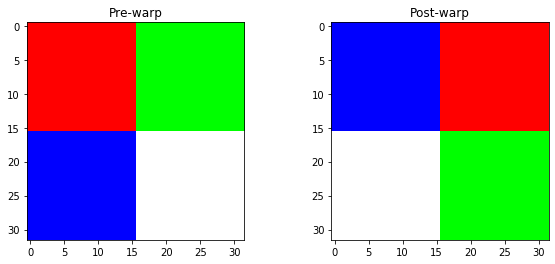

In [11]:
image1_origin = np.zeros((32, 32, 3), dtype=np.uint8)
image1_origin[:16, :16, 0] = 255 # top-left: red
image1_origin[:16, 16:, 1] = 255 # top-right: green
image1_origin[16:, :16, 2] = 255 # bottom-left: blue
image1_origin[16:, 16:, :] = 255 # bottom-right: white

image2_origin = np.zeros((32, 32, 3), dtype=np.uint8)
image2_origin[:16, :16, 2] = 255 # top-left: red
image2_origin[:16, 16:, 0] = 255 # top-right: green
image2_origin[16:, :16, :] = 255 # bottom-left: blue
image2_origin[16:, 16:, 1] = 255 # bottom-right: white

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Pre-warp')
ax1.imshow(image1_origin)

ax2 = fig.add_subplot(122)
ax2.set_title('Post-warp')
ax2.imshow(image2_origin)

plt.show()

## Define optical flow (cyclic)

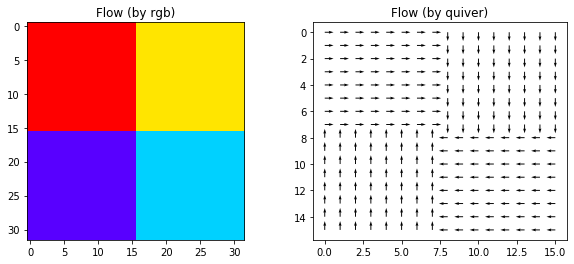

In [12]:
flow_origin = np.zeros((32, 32, 2), dtype=np.float32)
flow_origin[:16, :16, 0] = 16 # red (top-left) -> right
flow_origin[:16, 16:, 1] = 16 # green (top-right) -> bottom
flow_origin[16:, 16:, 0] = -16 # white (bottom-right) -> left
flow_origin[16:, :16, 1] = -16 # blue (bottom-left) -> top

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Flow (by rgb)')
ax1.imshow(flow_to_color(flow_origin))

ax2 = fig.add_subplot(122)
ax2.set_title('Flow (by quiver)')
ax2.quiver(*flow_to_quiver(flow_origin[::2, ::2]), angles='xy')
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

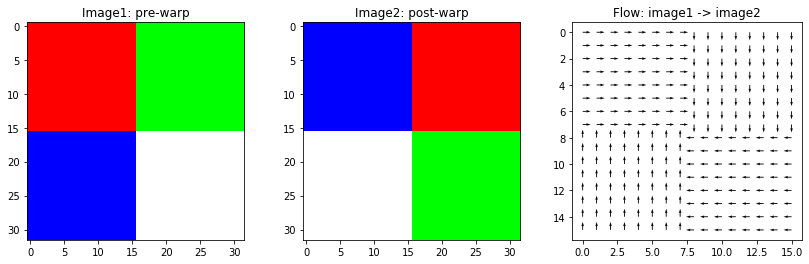

In [13]:
show_image_and_flow(image1_origin, image2_origin, flow_origin[::2, ::2])

# Validate preprocessing function

## Prepare initial tf.data.Dataset object

In [14]:
images1_origin = [image1_origin for i in range(10)]
images2_origin = [image2_origin for i in range(10)]
flows_origin = [flow_origin for i in range(10)]
dataset = tf.data.Dataset.from_tensor_slices((images1_origin, images2_origin, flows_origin))

## Run preprocessings

### Normalization

In [15]:
flow_scaler = 20
ds = dataset.map(partial(normalize, flow_scaler=flow_scaler))
im1, im2, flo = list(ds.as_numpy_iterator())[0]

print(f'Original stats: {image1_origin.max(), image2_origin.max(), flow_origin.max()}')
print(f'Processed stats: {im1.max(), im2.max(), flo.max()}')

Original stats: (255, 255, 16.0)
Processed stats: (1.0, 1.0, 0.8)


### Random crop

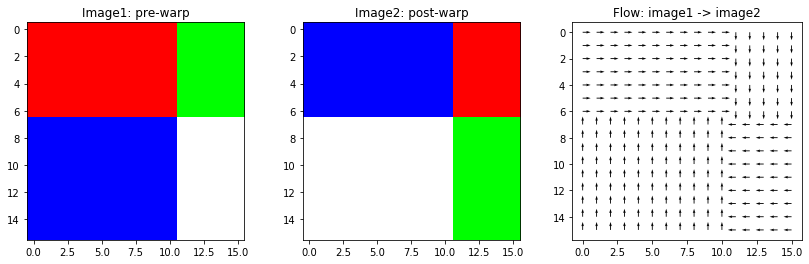

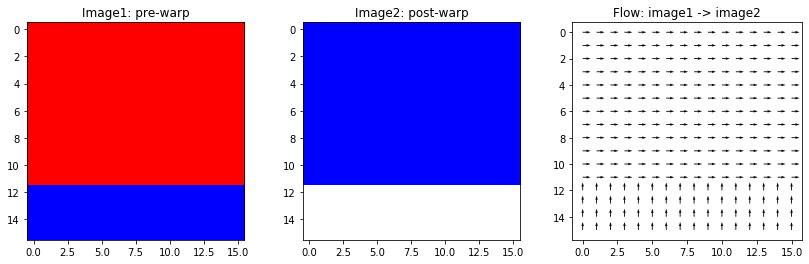

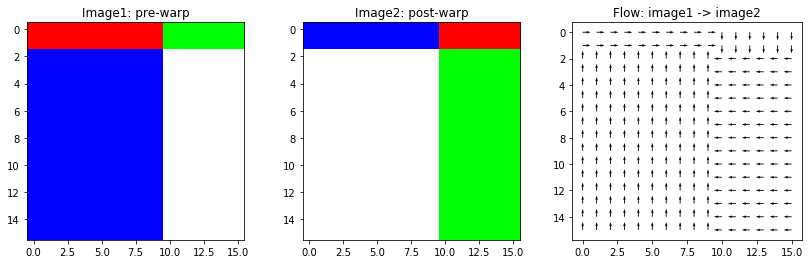

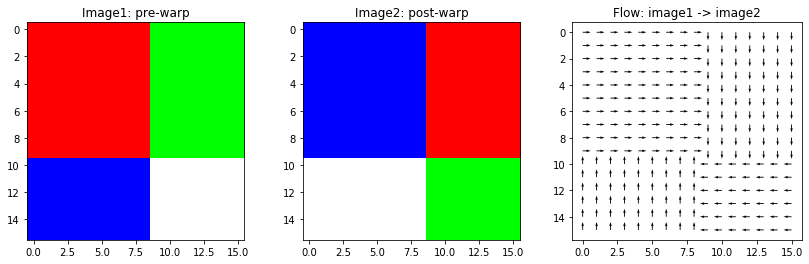

In [16]:
target_size = (16, 16)
ds_crop = ds.map(partial(random_crop, target_size=target_size))

for image1, image2, flow in ds_crop.take(4):
    show_image_and_flow(image1, image2, flow)

### Horizontal flip

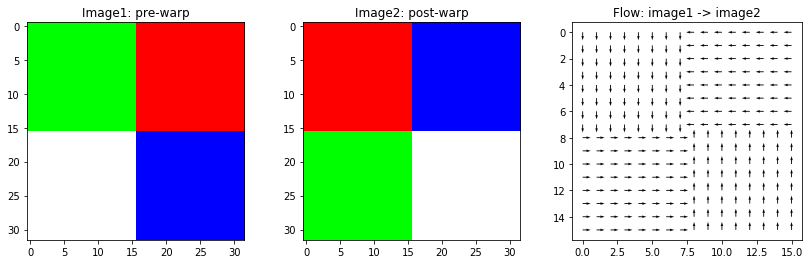

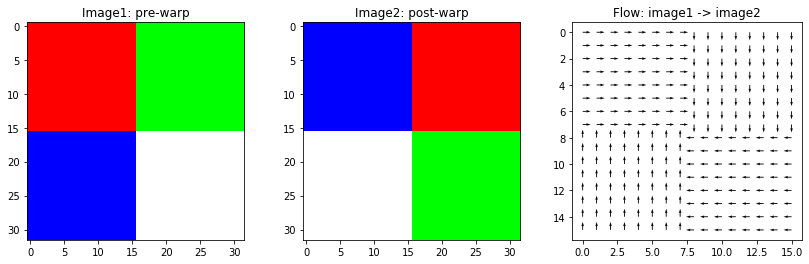

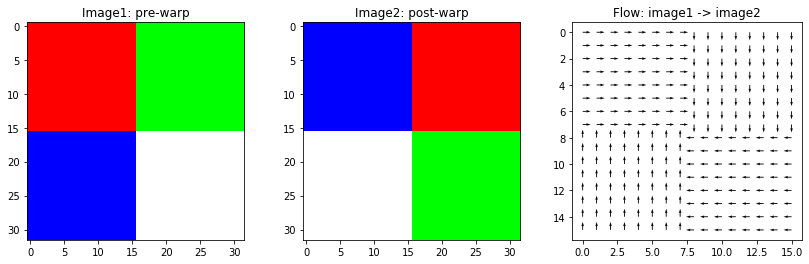

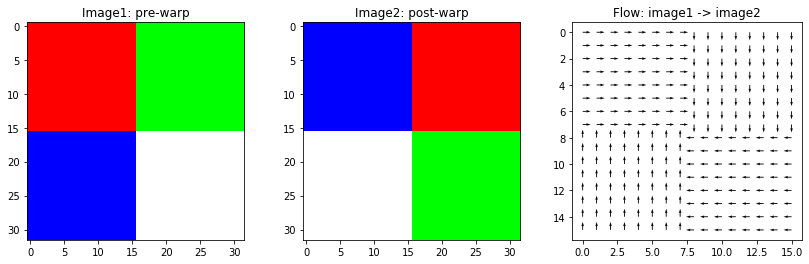

In [17]:
ds_hflip = ds.map(random_horizontal_flip)

for image1, image2, flow in ds_hflip.take(4):
    show_image_and_flow(image1, image2, flow[::2, ::2])

### Vertical flip

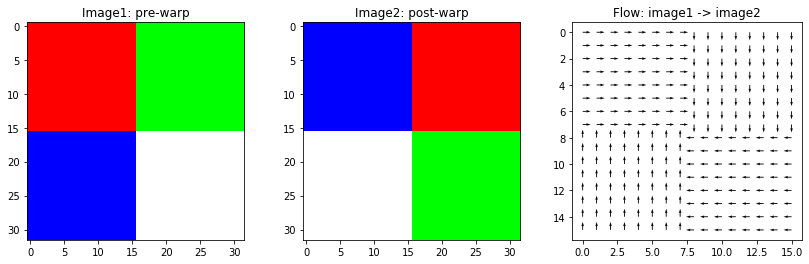

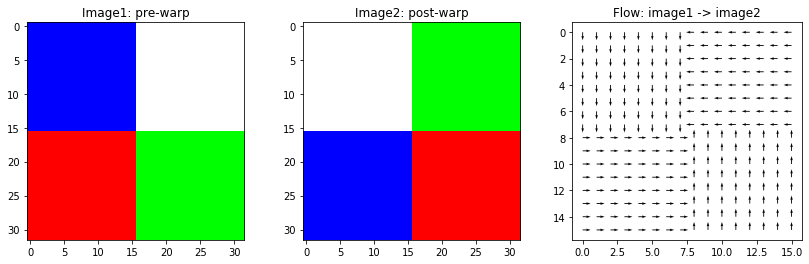

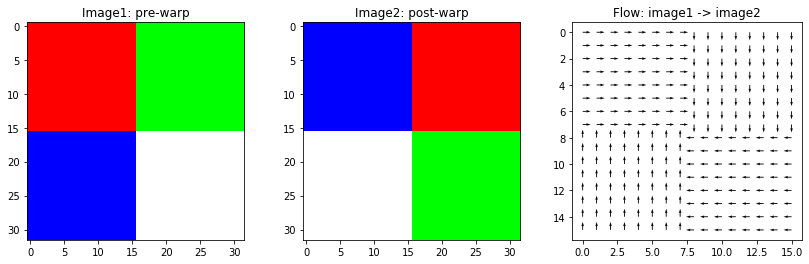

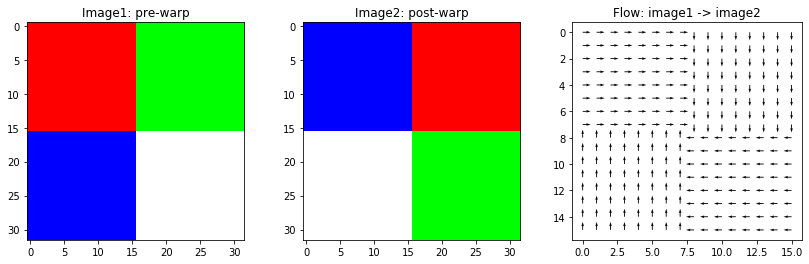

In [21]:
ds_vflip = ds.map(random_vertical_flip)

for image1, image2, flow in ds_vflip.take(4):
    show_image_and_flow(image1, image2, flow[::2, ::2])

# Validate Warping function

## Run warping function

In [25]:
x = list(ds.batch(1))[0]
x[0].shape

TensorShape([1, 32, 32, 3])

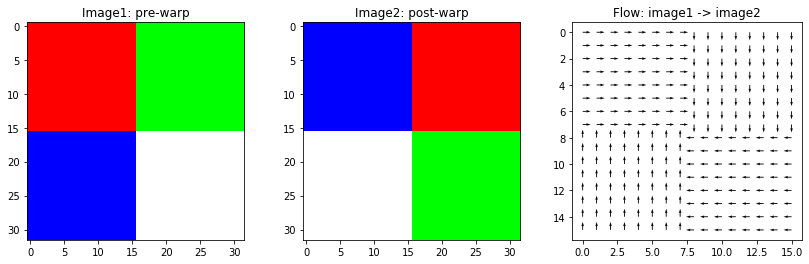

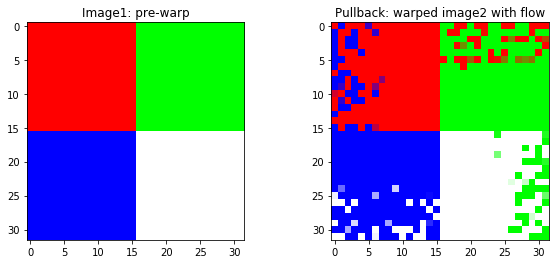

In [40]:
interpolation = 'bilinear' # 'nearest'
noise = tf.random.uniform((1, h, w, 2), 0.5, 1.5) # Only for validation 

image1, image2, flow = list(ds.batch(1))[0]
show_image_and_flow(image1.numpy()[0], image2.numpy()[0], flow.numpy()[0, ::2, ::2])

pullback = dense_warp(image2, flow*flow_scaler*noise, interpolation=interpolation)

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax1.set_title('Image1: pre-warp')
ax1.imshow(image1.numpy()[0])

ax2 = fig.add_subplot(122)
ax2.set_title('Pullback: warped image2 with flow')
ax2.imshow(pullback.numpy()[0])
plt.show()